# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#print(phos)

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)

idx   AAAS-S495  AAAS-S541  AAAS-Y485  AACS-S618  AAED1-S12  AAGAB-S310  \
S001        NaN        NaN        NaN    -0.8810    -1.8100         NaN   
S002        NaN        NaN        NaN        NaN     0.0840         NaN   
S003   -0.20200        NaN        NaN        NaN    -1.8800         NaN   
S004    0.25000        NaN        NaN        NaN        NaN         NaN   
S005   -0.00200        NaN     -0.407        NaN        NaN         NaN   
S006    0.55600    -0.0461        NaN        NaN     0.9410         NaN   
S007        NaN        NaN        NaN        NaN     0.0796         NaN   
S008    0.30000        NaN        NaN    -0.3710    -1.1400         NaN   
S009    0.49000        NaN        NaN        NaN        NaN         NaN   
S010   -0.23100     0.0108        NaN        NaN     0.2420         NaN   
S011    0.26800        NaN        NaN        NaN    -0.1120         NaN   
S012   -0.06200        NaN        NaN     1.8600    -1.4000         NaN   
S013   -1.49000        Na

## t-test for effects of all mutations combined
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

### List of interacting proteins (according to STRING and Uniprot)

In [4]:
#Build the protein list; this may have only a single protein if desired
#protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins
#protList = ['AHNAK','PPP1R12A']

In [5]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

In [6]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

In [7]:
print(significant_proteins)
print(significant_pvals)

[]
[]


### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [8]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = protList

In [15]:
sites = phos.columns
p_values = []
site_names = []

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
       
        for site in phosphositesdf.columns:
            #just making sure not to do comparison on mutation column
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
                #print(sitedf[99:140])
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                #if len(mutateddf) > 20:
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)
        


      IRS1-S1005  Mutation Patient_Type
S100    -0.10000  Wildtype        Tumor
S101     0.02290  Wildtype       Normal
S102    -0.14500  Wildtype       Normal
S103     1.53000  Wildtype       Normal
S104     0.39600  Wildtype       Normal
S105     0.80200  Wildtype       Normal
S106     0.88100  Wildtype       Normal
S107     0.48400  Wildtype       Normal
S108     0.19900  Wildtype       Normal
S109     1.03000  Wildtype       Normal
S110    -0.07940  Wildtype       Normal
S111     0.82300  Wildtype       Normal
S112    -0.05020  Wildtype       Normal
S113     0.25500  Wildtype       Normal
S114     0.05060  Wildtype       Normal
S115    -0.11700  Wildtype       Normal
S116     1.38000  Wildtype       Normal
S117     0.60800  Wildtype       Normal
S118     0.49700  Wildtype       Normal
S119     0.09540  Wildtype       Normal
S120     0.46000  Wildtype       Normal
S121     0.16800  Wildtype       Normal
S122     0.44300  Wildtype       Normal
S123     0.93100  Wildtype       Normal


      IRS1-S1227  Mutation Patient_Type
S100         NaN  Wildtype        Tumor
S101         NaN  Wildtype       Normal
S102         NaN  Wildtype       Normal
S103         NaN  Wildtype       Normal
S104         NaN  Wildtype       Normal
S105         NaN  Wildtype       Normal
S106         NaN  Wildtype       Normal
S107         NaN  Wildtype       Normal
S108         NaN  Wildtype       Normal
S109         NaN  Wildtype       Normal
S110         NaN  Wildtype       Normal
S111         NaN  Wildtype       Normal
S112         NaN  Wildtype       Normal
S113         NaN  Wildtype       Normal
S114         NaN  Wildtype       Normal
S115         NaN  Wildtype       Normal
S116         NaN  Wildtype       Normal
S117         NaN  Wildtype       Normal
S118         NaN  Wildtype       Normal
S119         NaN  Wildtype       Normal
S120         NaN  Wildtype       Normal
S121         NaN  Wildtype       Normal
S122         NaN  Wildtype       Normal
S123         NaN  Wildtype       Normal


      IRS1-S374  Mutation Patient_Type
S100     0.0264  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102    -0.0344  Wildtype       Normal
S103    -0.4110  Wildtype       Normal
S104     0.2390  Wildtype       Normal
S105     0.0265  Wildtype       Normal
S106     1.3700  Wildtype       Normal
S107     1.0100  Wildtype       Normal
S108     1.3300  Wildtype       Normal
S109     0.6540  Wildtype       Normal
S110     0.3310  Wildtype       Normal
S111     1.2700  Wildtype       Normal
S112     0.8440  Wildtype       Normal
S113     0.5880  Wildtype       Normal
S114     0.7690  Wildtype       Normal
S115     0.7580  Wildtype       Normal
S116     0.2510  Wildtype       Normal
S117     1.0900  Wildtype       Normal
S118     1.4200  Wildtype       Normal
S119     1.4500  Wildtype       Normal
S120     0.8300  Wildtype       Normal
S121     1.2500  Wildtype       Normal
S122     0.9870  Wildtype       Normal
S123     0.2560  Wildtype       Normal
S124     0.4310  Wildtype

      IRS1-S513  Mutation Patient_Type
S100        NaN  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102      0.224  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104      0.312  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      IRS1-S672  Mutation Patient_Type
S100    0.50900  Wildtype        Tumor
S101   -0.03225  Wildtype       Normal
S102   -0.10400  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104    0.02250  Wildtype       Normal
S105    0.40900  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107    1.20000  Wildtype       Normal
S108    0.67900  Wildtype       Normal
S109    0.21900  Wildtype       Normal
S110    0.29000  Wildtype       Normal
S111    1.72000  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113    1.64000  Wildtype       Normal
S114    0.34000  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118    0.46800  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124    1.28000  Wildtype

      IRS1-T446  Mutation Patient_Type
S100        NaN  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102  -1.070000  Wildtype       Normal
S103  -0.209000  Wildtype       Normal
S104  -0.458000  Wildtype       Normal
S105   0.176500  Wildtype       Normal
S106   0.488000  Wildtype       Normal
S107   1.200000  Wildtype       Normal
S108   0.881000  Wildtype       Normal
S109  -0.221500  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111   0.845500  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113   0.365000  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115   0.422000  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117   0.114000  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119   0.885000  Wildtype       Normal
S120   0.170000  Wildtype       Normal
S121   0.354000  Wildtype       Normal
S122  -0.207000  Wildtype       Normal
S123  -1.510000  Wildtype       Normal
S124   0.023000  Wildtype

      IRS2-S1100  Mutation Patient_Type
S100       0.184  Wildtype        Tumor
S101       0.249  Wildtype       Normal
S102       0.460  Wildtype       Normal
S103      -0.135  Wildtype       Normal
S104       0.719  Wildtype       Normal
S105       1.020  Wildtype       Normal
S106       0.117  Wildtype       Normal
S107       0.958  Wildtype       Normal
S108       1.740  Wildtype       Normal
S109       0.717  Wildtype       Normal
S110       0.177  Wildtype       Normal
S111       0.403  Wildtype       Normal
S112       0.923  Wildtype       Normal
S113       0.951  Wildtype       Normal
S114       0.800  Wildtype       Normal
S115       0.571  Wildtype       Normal
S116       1.010  Wildtype       Normal
S117       1.320  Wildtype       Normal
S118      -0.015  Wildtype       Normal
S119       0.806  Wildtype       Normal
S120       0.818  Wildtype       Normal
S121       0.909  Wildtype       Normal
S122       0.362  Wildtype       Normal
S123       0.617  Wildtype       Normal


S140        NaN  Wildtype       Normal
      IRS2-S346  Mutation Patient_Type
S100        NaN  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102        NaN  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104        NaN  Wildtype       Normal
S105     0.0539  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109    -0.4860  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype

      IRS2-S608  Mutation Patient_Type
S100        NaN  Wildtype        Tumor
S101      0.825  Wildtype       Normal
S102     -0.981  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104      0.696  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119      1.100  Wildtype       Normal
S120      0.541  Wildtype       Normal
S121      1.100  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      IRS2-S828  Mutation Patient_Type
S100        NaN  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102        NaN  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104        NaN  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107      0.529  Wildtype       Normal
S108      0.523  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      IRS2-T363  Mutation Patient_Type
S100  -0.283500  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102        NaN  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104        NaN  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      RRAS-S201  Mutation Patient_Type
S100        NaN  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102        NaN  Wildtype       Normal
S103      0.471  Wildtype       Normal
S104        NaN  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      AKT2-T449  Mutation Patient_Type
S100    -0.4170  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102        NaN  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104        NaN  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      PTEN-S543  Mutation Patient_Type
S100     0.7265  Wildtype        Tumor
S101     0.8980  Wildtype       Normal
S102     0.0000  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104     0.4340  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      AKT1-T450  Mutation Patient_Type
S100    0.00000  Wildtype        Tumor
S101        NaN  Wildtype       Normal
S102   -0.00828  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104    0.12700  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      AKT1S1-T218  Mutation Patient_Type
S100          NaN  Wildtype        Tumor
S101          NaN  Wildtype       Normal
S102       0.0000  Wildtype       Normal
S103          NaN  Wildtype       Normal
S104       0.6430  Wildtype       Normal
S105          NaN  Wildtype       Normal
S106          NaN  Wildtype       Normal
S107          NaN  Wildtype       Normal
S108          NaN  Wildtype       Normal
S109          NaN  Wildtype       Normal
S110          NaN  Wildtype       Normal
S111       0.2400  Wildtype       Normal
S112      -0.0314  Wildtype       Normal
S113       0.0000  Wildtype       Normal
S114          NaN  Wildtype       Normal
S115          NaN  Wildtype       Normal
S116      -0.0998  Wildtype       Normal
S117          NaN  Wildtype       Normal
S118          NaN  Wildtype       Normal
S119          NaN  Wildtype       Normal
S120          NaN  Wildtype       Normal
S121          NaN  Wildtype       Normal
S122          NaN  Wildtype       Normal
S123          Na

      PIK3R1-S154  Mutation Patient_Type
S100      0.10700  Wildtype        Tumor
S101     -0.67200  Wildtype       Normal
S102      0.07170  Wildtype       Normal
S103     -0.47800  Wildtype       Normal
S104      0.22700  Wildtype       Normal
S105     -0.94500  Wildtype       Normal
S106          NaN  Wildtype       Normal
S107      0.18400  Wildtype       Normal
S108     -0.39000  Wildtype       Normal
S109     -0.72600  Wildtype       Normal
S110      0.43800  Wildtype       Normal
S111     -0.65000  Wildtype       Normal
S112      0.00664  Wildtype       Normal
S113     -0.25700  Wildtype       Normal
S114      1.17000  Wildtype       Normal
S115          NaN  Wildtype       Normal
S116     -0.35600  Wildtype       Normal
S117     -0.47800  Wildtype       Normal
S118     -0.16900  Wildtype       Normal
S119          NaN  Wildtype       Normal
S120          NaN  Wildtype       Normal
S121          NaN  Wildtype       Normal
S122     -0.63800  Wildtype       Normal
S123     -0.2350

      ITPKC-S362  Mutation Patient_Type
S100         NaN  Wildtype        Tumor
S101       0.128  Wildtype       Normal
S102         NaN  Wildtype       Normal
S103         NaN  Wildtype       Normal
S104         NaN  Wildtype       Normal
S105         NaN  Wildtype       Normal
S106         NaN  Wildtype       Normal
S107         NaN  Wildtype       Normal
S108         NaN  Wildtype       Normal
S109         NaN  Wildtype       Normal
S110         NaN  Wildtype       Normal
S111         NaN  Wildtype       Normal
S112         NaN  Wildtype       Normal
S113         NaN  Wildtype       Normal
S114         NaN  Wildtype       Normal
S115         NaN  Wildtype       Normal
S116         NaN  Wildtype       Normal
S117         NaN  Wildtype       Normal
S118         NaN  Wildtype       Normal
S119         NaN  Wildtype       Normal
S120         NaN  Wildtype       Normal
S121         NaN  Wildtype       Normal
S122         NaN  Wildtype       Normal
S123         NaN  Wildtype       Normal


      LAMTOR1-S42  Mutation Patient_Type
S100       0.5660  Wildtype        Tumor
S101       0.7820  Wildtype       Normal
S102       1.0300  Wildtype       Normal
S103       0.2260  Wildtype       Normal
S104       0.3260  Wildtype       Normal
S105      -0.2000  Wildtype       Normal
S106          NaN  Wildtype       Normal
S107      -0.0920  Wildtype       Normal
S108      -0.3800  Wildtype       Normal
S109      -0.4010  Wildtype       Normal
S110      -0.2290  Wildtype       Normal
S111      -0.4620  Wildtype       Normal
S112       0.0971  Wildtype       Normal
S113      -0.7640  Wildtype       Normal
S114      -0.6720  Wildtype       Normal
S115          NaN  Wildtype       Normal
S116       0.2360  Wildtype       Normal
S117      -0.5680  Wildtype       Normal
S118      -0.0116  Wildtype       Normal
S119      -0.0636  Wildtype       Normal
S120      -0.0941  Wildtype       Normal
S121       0.1070  Wildtype       Normal
S122      -0.4770  Wildtype       Normal
S123       0.281

      MTOR-S2069  Mutation Patient_Type
S100         NaN  Wildtype        Tumor
S101         NaN  Wildtype       Normal
S102         NaN  Wildtype       Normal
S103         NaN  Wildtype       Normal
S104         NaN  Wildtype       Normal
S105         NaN  Wildtype       Normal
S106         NaN  Wildtype       Normal
S107         NaN  Wildtype       Normal
S108         NaN  Wildtype       Normal
S109         NaN  Wildtype       Normal
S110         NaN  Wildtype       Normal
S111         NaN  Wildtype       Normal
S112         NaN  Wildtype       Normal
S113         NaN  Wildtype       Normal
S114         NaN  Wildtype       Normal
S115         NaN  Wildtype       Normal
S116         NaN  Wildtype       Normal
S117         NaN  Wildtype       Normal
S118         NaN  Wildtype       Normal
S119         NaN  Wildtype       Normal
S120         NaN  Wildtype       Normal
S121         NaN  Wildtype       Normal
S122         NaN  Wildtype       Normal
S123         NaN  Wildtype       Normal


      MTOR-Y2449  Mutation Patient_Type
S100         NaN  Wildtype        Tumor
S101         NaN  Wildtype       Normal
S102         NaN  Wildtype       Normal
S103     -0.2520  Wildtype       Normal
S104         NaN  Wildtype       Normal
S105      0.3000  Wildtype       Normal
S106         NaN  Wildtype       Normal
S107         NaN  Wildtype       Normal
S108         NaN  Wildtype       Normal
S109      0.3900  Wildtype       Normal
S110         NaN  Wildtype       Normal
S111      0.3370  Wildtype       Normal
S112         NaN  Wildtype       Normal
S113      0.1070  Wildtype       Normal
S114         NaN  Wildtype       Normal
S115         NaN  Wildtype       Normal
S116         NaN  Wildtype       Normal
S117         NaN  Wildtype       Normal
S118         NaN  Wildtype       Normal
S119         NaN  Wildtype       Normal
S120         NaN  Wildtype       Normal
S121         NaN  Wildtype       Normal
S122         NaN  Wildtype       Normal
S123         NaN  Wildtype       Normal


      RPS6KA1-S54  Mutation Patient_Type
S100          NaN  Wildtype        Tumor
S101          NaN  Wildtype       Normal
S102          NaN  Wildtype       Normal
S103          NaN  Wildtype       Normal
S104          NaN  Wildtype       Normal
S105          NaN  Wildtype       Normal
S106          NaN  Wildtype       Normal
S107          NaN  Wildtype       Normal
S108          NaN  Wildtype       Normal
S109          NaN  Wildtype       Normal
S110          NaN  Wildtype       Normal
S111          NaN  Wildtype       Normal
S112          NaN  Wildtype       Normal
S113          NaN  Wildtype       Normal
S114          NaN  Wildtype       Normal
S115          NaN  Wildtype       Normal
S116          NaN  Wildtype       Normal
S117          NaN  Wildtype       Normal
S118          NaN  Wildtype       Normal
S119          NaN  Wildtype       Normal
S120          NaN  Wildtype       Normal
S121          NaN  Wildtype       Normal
S122          NaN  Wildtype       Normal
S123          Na

      RPS6KA2-T599  Mutation Patient_Type
S100        -0.029  Wildtype        Tumor
S101           NaN  Wildtype       Normal
S102           NaN  Wildtype       Normal
S103           NaN  Wildtype       Normal
S104           NaN  Wildtype       Normal
S105           NaN  Wildtype       Normal
S106           NaN  Wildtype       Normal
S107           NaN  Wildtype       Normal
S108           NaN  Wildtype       Normal
S109           NaN  Wildtype       Normal
S110           NaN  Wildtype       Normal
S111           NaN  Wildtype       Normal
S112           NaN  Wildtype       Normal
S113           NaN  Wildtype       Normal
S114           NaN  Wildtype       Normal
S115           NaN  Wildtype       Normal
S116           NaN  Wildtype       Normal
S117           NaN  Wildtype       Normal
S118           NaN  Wildtype       Normal
S119           NaN  Wildtype       Normal
S120           NaN  Wildtype       Normal
S121           NaN  Wildtype       Normal
S122           NaN  Wildtype      

      RPS6KA3-T365  Mutation Patient_Type
S100      -0.18615  Wildtype        Tumor
S101       0.04390  Wildtype       Normal
S102       0.57600  Wildtype       Normal
S103      -0.00550  Wildtype       Normal
S104       0.02650  Wildtype       Normal
S105       1.02650  Wildtype       Normal
S106       0.28300  Wildtype       Normal
S107       0.23000  Wildtype       Normal
S108       0.55850  Wildtype       Normal
S109       0.68450  Wildtype       Normal
S110       0.19200  Wildtype       Normal
S111       0.08750  Wildtype       Normal
S112       0.37000  Wildtype       Normal
S113       0.47350  Wildtype       Normal
S114       0.30500  Wildtype       Normal
S115       0.04140  Wildtype       Normal
S116       0.73800  Wildtype       Normal
S117       0.29800  Wildtype       Normal
S118      -0.05170  Wildtype       Normal
S119       0.59300  Wildtype       Normal
S120       1.40000  Wildtype       Normal
S121       0.81300  Wildtype       Normal
S122       0.09270  Wildtype      

      RPS6KA4-T22  Mutation Patient_Type
S100     0.455000  Wildtype        Tumor
S101          NaN  Wildtype       Normal
S102    -0.847000  Wildtype       Normal
S103     0.700000  Wildtype       Normal
S104     1.490000  Wildtype       Normal
S105          NaN  Wildtype       Normal
S106          NaN  Wildtype       Normal
S107     1.520000  Wildtype       Normal
S108     1.410000  Wildtype       Normal
S109          NaN  Wildtype       Normal
S110          NaN  Wildtype       Normal
S111     0.280000  Wildtype       Normal
S112     0.000633  Wildtype       Normal
S113     0.928000  Wildtype       Normal
S114          NaN  Wildtype       Normal
S115          NaN  Wildtype       Normal
S116     0.144000  Wildtype       Normal
S117          NaN  Wildtype       Normal
S118          NaN  Wildtype       Normal
S119          NaN  Wildtype       Normal
S120          NaN  Wildtype       Normal
S121          NaN  Wildtype       Normal
S122          NaN  Wildtype       Normal
S123          Na

      RPS6KA5-S752  Mutation Patient_Type
S100           NaN  Wildtype        Tumor
S101       -1.3400  Wildtype       Normal
S102           NaN  Wildtype       Normal
S103           NaN  Wildtype       Normal
S104           NaN  Wildtype       Normal
S105        0.1130  Wildtype       Normal
S106           NaN  Wildtype       Normal
S107           NaN  Wildtype       Normal
S108           NaN  Wildtype       Normal
S109        0.1440  Wildtype       Normal
S110           NaN  Wildtype       Normal
S111           NaN  Wildtype       Normal
S112           NaN  Wildtype       Normal
S113           NaN  Wildtype       Normal
S114           NaN  Wildtype       Normal
S115           NaN  Wildtype       Normal
S116           NaN  Wildtype       Normal
S117           NaN  Wildtype       Normal
S118           NaN  Wildtype       Normal
S119       -0.0966  Wildtype       Normal
S120        0.6480  Wildtype       Normal
S121       -0.6550  Wildtype       Normal
S122        0.1450  Wildtype      

      RPS6KB1-T444  Mutation Patient_Type
S100       0.42850  Wildtype        Tumor
S101       0.05040  Wildtype       Normal
S102       0.29100  Wildtype       Normal
S103       0.08310  Wildtype       Normal
S104       0.08100  Wildtype       Normal
S105       0.88600  Wildtype       Normal
S106       0.29800  Wildtype       Normal
S107      -0.08560  Wildtype       Normal
S108       0.15800  Wildtype       Normal
S109       0.45900  Wildtype       Normal
S110      -0.13090  Wildtype       Normal
S111      -0.76500  Wildtype       Normal
S112      -0.31450  Wildtype       Normal
S113       0.05850  Wildtype       Normal
S114      -1.03500  Wildtype       Normal
S115      -0.40000  Wildtype       Normal
S116       0.04255  Wildtype       Normal
S117           NaN  Wildtype       Normal
S118      -0.34050  Wildtype       Normal
S119       0.21650  Wildtype       Normal
S120       0.79100  Wildtype       Normal
S121       0.07130  Wildtype       Normal
S122           NaN  Wildtype      

      RPS6KC1-S449  Mutation Patient_Type
S100      0.052500  Wildtype        Tumor
S101     -0.126000  Wildtype       Normal
S102     -0.024400  Wildtype       Normal
S103     -0.091300  Wildtype       Normal
S104     -0.686000  Wildtype       Normal
S105           NaN  Wildtype       Normal
S106           NaN  Wildtype       Normal
S107           NaN  Wildtype       Normal
S108           NaN  Wildtype       Normal
S109           NaN  Wildtype       Normal
S110     -0.389000  Wildtype       Normal
S111           NaN  Wildtype       Normal
S112     -0.273000  Wildtype       Normal
S113           NaN  Wildtype       Normal
S114     -0.357000  Wildtype       Normal
S115           NaN  Wildtype       Normal
S116     -0.254000  Wildtype       Normal
S117     -1.160000  Wildtype       Normal
S118     -0.532000  Wildtype       Normal
S119     -0.701000  Wildtype       Normal
S120     -0.366000  Wildtype       Normal
S121     -0.553000  Wildtype       Normal
S122     -1.040000  Wildtype      

      RPS6KC1-S610  Mutation Patient_Type
S100           NaN  Wildtype        Tumor
S101           NaN  Wildtype       Normal
S102           NaN  Wildtype       Normal
S103           NaN  Wildtype       Normal
S104           NaN  Wildtype       Normal
S105           NaN  Wildtype       Normal
S106           NaN  Wildtype       Normal
S107           NaN  Wildtype       Normal
S108           NaN  Wildtype       Normal
S109           NaN  Wildtype       Normal
S110           NaN  Wildtype       Normal
S111           NaN  Wildtype       Normal
S112           NaN  Wildtype       Normal
S113           NaN  Wildtype       Normal
S114           NaN  Wildtype       Normal
S115           NaN  Wildtype       Normal
S116           NaN  Wildtype       Normal
S117         0.416  Wildtype       Normal
S118           NaN  Wildtype       Normal
S119           NaN  Wildtype       Normal
S120           NaN  Wildtype       Normal
S121           NaN  Wildtype       Normal
S122         0.482  Wildtype      

S140           NaN  Wildtype       Normal
      MAPK1-T181  Mutation Patient_Type
S100     0.37000  Wildtype        Tumor
S101         NaN  Wildtype       Normal
S102         NaN  Wildtype       Normal
S103    -1.50000  Wildtype       Normal
S104         NaN  Wildtype       Normal
S105     3.65000  Wildtype       Normal
S106     0.49800  Wildtype       Normal
S107    -0.10300  Wildtype       Normal
S108    -0.06360  Wildtype       Normal
S109     1.85000  Wildtype       Normal
S110     2.02000  Wildtype       Normal
S111     0.26530  Wildtype       Normal
S112     0.48400  Wildtype       Normal
S113     1.02500  Wildtype       Normal
S114    -0.03900  Wildtype       Normal
S115     0.07190  Wildtype       Normal
S116     1.76000  Wildtype       Normal
S117     2.70000  Wildtype       Normal
S118    -0.24500  Wildtype       Normal
S119     0.41000  Wildtype       Normal
S120     1.46000  Wildtype       Normal
S121    -0.36600  Wildtype       Normal
S122    -0.15900  Wildtype       Norma

      MAPK13-S350  Mutation Patient_Type
S100          NaN  Wildtype        Tumor
S101          NaN  Wildtype       Normal
S102      -0.0315  Wildtype       Normal
S103          NaN  Wildtype       Normal
S104       0.0316  Wildtype       Normal
S105          NaN  Wildtype       Normal
S106      -0.5830  Wildtype       Normal
S107          NaN  Wildtype       Normal
S108          NaN  Wildtype       Normal
S109          NaN  Wildtype       Normal
S110          NaN  Wildtype       Normal
S111          NaN  Wildtype       Normal
S112          NaN  Wildtype       Normal
S113          NaN  Wildtype       Normal
S114          NaN  Wildtype       Normal
S115      -0.7360  Wildtype       Normal
S116          NaN  Wildtype       Normal
S117          NaN  Wildtype       Normal
S118          NaN  Wildtype       Normal
S119          NaN  Wildtype       Normal
S120          NaN  Wildtype       Normal
S121          NaN  Wildtype       Normal
S122          NaN  Wildtype       Normal
S123          Na

      MAPK1IP1L-S15  Mutation Patient_Type
S100            NaN  Wildtype        Tumor
S101            NaN  Wildtype       Normal
S102            NaN  Wildtype       Normal
S103            NaN  Wildtype       Normal
S104            NaN  Wildtype       Normal
S105         0.1490  Wildtype       Normal
S106            NaN  Wildtype       Normal
S107        -0.4890  Wildtype       Normal
S108        -0.2610  Wildtype       Normal
S109        -0.0900  Wildtype       Normal
S110            NaN  Wildtype       Normal
S111            NaN  Wildtype       Normal
S112            NaN  Wildtype       Normal
S113            NaN  Wildtype       Normal
S114            NaN  Wildtype       Normal
S115            NaN  Wildtype       Normal
S116            NaN  Wildtype       Normal
S117            NaN  Wildtype       Normal
S118            NaN  Wildtype       Normal
S119            NaN  Wildtype       Normal
S120            NaN  Wildtype       Normal
S121            NaN  Wildtype       Normal
S122       

      MAPK6-S556  Mutation Patient_Type
S100     -0.5390  Wildtype        Tumor
S101     -0.8350  Wildtype       Normal
S102         NaN  Wildtype       Normal
S103         NaN  Wildtype       Normal
S104         NaN  Wildtype       Normal
S105     -0.3010  Wildtype       Normal
S106         NaN  Wildtype       Normal
S107         NaN  Wildtype       Normal
S108         NaN  Wildtype       Normal
S109     -0.2620  Wildtype       Normal
S110         NaN  Wildtype       Normal
S111         NaN  Wildtype       Normal
S112         NaN  Wildtype       Normal
S113         NaN  Wildtype       Normal
S114         NaN  Wildtype       Normal
S115         NaN  Wildtype       Normal
S116         NaN  Wildtype       Normal
S117         NaN  Wildtype       Normal
S118         NaN  Wildtype       Normal
S119         NaN  Wildtype       Normal
S120         NaN  Wildtype       Normal
S121         NaN  Wildtype       Normal
S122         NaN  Wildtype       Normal
S123         NaN  Wildtype       Normal


S140      -0.585000  Wildtype       Normal
      MAPK8IP3-S586  Mutation Patient_Type
S100         1.6900  Wildtype        Tumor
S101        -0.4160  Wildtype       Normal
S102            NaN  Wildtype       Normal
S103            NaN  Wildtype       Normal
S104            NaN  Wildtype       Normal
S105            NaN  Wildtype       Normal
S106            NaN  Wildtype       Normal
S107        -0.4800  Wildtype       Normal
S108         0.1180  Wildtype       Normal
S109            NaN  Wildtype       Normal
S110         0.8860  Wildtype       Normal
S111         0.0612  Wildtype       Normal
S112            NaN  Wildtype       Normal
S113         0.2740  Wildtype       Normal
S114         0.3710  Wildtype       Normal
S115            NaN  Wildtype       Normal
S116            NaN  Wildtype       Normal
S117            NaN  Wildtype       Normal
S118         0.2300  Wildtype       Normal
S119        -0.2110  Wildtype       Normal
S120        -0.0576  Wildtype       Normal
S121       

      MAPKAP1-S186  Mutation Patient_Type
S100           NaN  Wildtype        Tumor
S101           NaN  Wildtype       Normal
S102       0.23500  Wildtype       Normal
S103       0.27800  Wildtype       Normal
S104       0.58200  Wildtype       Normal
S105       0.01940  Wildtype       Normal
S106           NaN  Wildtype       Normal
S107       0.16785  Wildtype       Normal
S108      -0.31050  Wildtype       Normal
S109      -0.07140  Wildtype       Normal
S110      -0.08520  Wildtype       Normal
S111      -0.22700  Wildtype       Normal
S112           NaN  Wildtype       Normal
S113      -0.45500  Wildtype       Normal
S114       0.37900  Wildtype       Normal
S115           NaN  Wildtype       Normal
S116           NaN  Wildtype       Normal
S117           NaN  Wildtype       Normal
S118      -0.12600  Wildtype       Normal
S119           NaN  Wildtype       Normal
S120           NaN  Wildtype       Normal
S121           NaN  Wildtype       Normal
S122           NaN  Wildtype      

      MAPKAPK2-Y229  Mutation Patient_Type
S100            NaN  Wildtype        Tumor
S101            NaN  Wildtype       Normal
S102            NaN  Wildtype       Normal
S103            NaN  Wildtype       Normal
S104            NaN  Wildtype       Normal
S105            NaN  Wildtype       Normal
S106            NaN  Wildtype       Normal
S107            NaN  Wildtype       Normal
S108            NaN  Wildtype       Normal
S109            NaN  Wildtype       Normal
S110            NaN  Wildtype       Normal
S111            NaN  Wildtype       Normal
S112            NaN  Wildtype       Normal
S113            NaN  Wildtype       Normal
S114            NaN  Wildtype       Normal
S115            NaN  Wildtype       Normal
S116            NaN  Wildtype       Normal
S117            NaN  Wildtype       Normal
S118            NaN  Wildtype       Normal
S119        0.00194  Wildtype       Normal
S120        0.35700  Wildtype       Normal
S121       -0.01250  Wildtype       Normal
S122       

      MAPKBP1-S1198  Mutation Patient_Type
S100       0.731000  Wildtype        Tumor
S101      -1.140000  Wildtype       Normal
S102      -0.172000  Wildtype       Normal
S103      -0.329000  Wildtype       Normal
S104      -0.437000  Wildtype       Normal
S105       0.076100  Wildtype       Normal
S106       0.618000  Wildtype       Normal
S107       0.347000  Wildtype       Normal
S108       0.000516  Wildtype       Normal
S109      -0.059600  Wildtype       Normal
S110            NaN  Wildtype       Normal
S111       0.101000  Wildtype       Normal
S112      -0.160000  Wildtype       Normal
S113       0.107000  Wildtype       Normal
S114            NaN  Wildtype       Normal
S115       0.533000  Wildtype       Normal
S116      -0.368000  Wildtype       Normal
S117       1.310000  Wildtype       Normal
S118            NaN  Wildtype       Normal
S119       0.357000  Wildtype       Normal
S120      -0.059000  Wildtype       Normal
S121      -0.107000  Wildtype       Normal
S122      -

      MAPKBP1-T796  Mutation Patient_Type
S100           NaN  Wildtype        Tumor
S101           NaN  Wildtype       Normal
S102           NaN  Wildtype       Normal
S103           NaN  Wildtype       Normal
S104           NaN  Wildtype       Normal
S105           NaN  Wildtype       Normal
S106           NaN  Wildtype       Normal
S107           NaN  Wildtype       Normal
S108           NaN  Wildtype       Normal
S109           NaN  Wildtype       Normal
S110           NaN  Wildtype       Normal
S111           NaN  Wildtype       Normal
S112           NaN  Wildtype       Normal
S113           NaN  Wildtype       Normal
S114           NaN  Wildtype       Normal
S115           NaN  Wildtype       Normal
S116           NaN  Wildtype       Normal
S117           NaN  Wildtype       Normal
S118           NaN  Wildtype       Normal
S119           NaN  Wildtype       Normal
S120           NaN  Wildtype       Normal
S121           NaN  Wildtype       Normal
S122           NaN  Wildtype      

      CDK5-S229  Mutation Patient_Type
S100   -0.50400  Wildtype        Tumor
S101   -0.82500  Wildtype       Normal
S102   -0.63800  Wildtype       Normal
S103        NaN  Wildtype       Normal
S104    0.70800  Wildtype       Normal
S105        NaN  Wildtype       Normal
S106        NaN  Wildtype       Normal
S107        NaN  Wildtype       Normal
S108        NaN  Wildtype       Normal
S109        NaN  Wildtype       Normal
S110        NaN  Wildtype       Normal
S111        NaN  Wildtype       Normal
S112        NaN  Wildtype       Normal
S113        NaN  Wildtype       Normal
S114        NaN  Wildtype       Normal
S115        NaN  Wildtype       Normal
S116        NaN  Wildtype       Normal
S117        NaN  Wildtype       Normal
S118        NaN  Wildtype       Normal
S119        NaN  Wildtype       Normal
S120        NaN  Wildtype       Normal
S121        NaN  Wildtype       Normal
S122        NaN  Wildtype       Normal
S123        NaN  Wildtype       Normal
S124        NaN  Wildtype

      CDK5RAP2-S576  Mutation Patient_Type
S100         0.4140  Wildtype        Tumor
S101            NaN  Wildtype       Normal
S102            NaN  Wildtype       Normal
S103            NaN  Wildtype       Normal
S104            NaN  Wildtype       Normal
S105            NaN  Wildtype       Normal
S106            NaN  Wildtype       Normal
S107            NaN  Wildtype       Normal
S108            NaN  Wildtype       Normal
S109            NaN  Wildtype       Normal
S110            NaN  Wildtype       Normal
S111            NaN  Wildtype       Normal
S112            NaN  Wildtype       Normal
S113            NaN  Wildtype       Normal
S114            NaN  Wildtype       Normal
S115            NaN  Wildtype       Normal
S116            NaN  Wildtype       Normal
S117            NaN  Wildtype       Normal
S118            NaN  Wildtype       Normal
S119            NaN  Wildtype       Normal
S120            NaN  Wildtype       Normal
S121            NaN  Wildtype       Normal
S122       

### Seeing significance of P values using bonferroni correction

In [10]:
threshold_pval = .05/len(site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_sig_sites = list()
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_sig_sites.append(site_names[ind])
        
        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  0.00011185682326621924


### Print signifcant p-values

In [11]:
#print("\nSignificant P-values from Bonferroni: ", bonferonni_corrected_pvals)
#print("\nSignificant Sites from Bonferroni: ", bonferonni_sig_sites)
#sortedkeys = sort(bf_significant_vals.keys())
#for key in sortedkeys:
#    print (key, bf_significant_vals[key])
#print("\nSignificant values: ", bf_significant_vals)

for key in sorted(bf_significant_vals):
    #print(%s: %s % (key, bf_significant_vals[key]))
    print(key, bf_significant_vals[key])

print(len(bonferonni_sig_sites))
print(len(bonferonni_corrected_pvals))
print(len(site_names))


#indexMin = bonferonni_corrected_pvals.index(min(bonferonni_corrected_pvals))

#print("Min P-val: ", bonferonni_corrected_pvals[index_min])
#print("Site name at min: ", bonferonni_sig_sites[index_min])

0
0
447


### Use FDR Correction

In [12]:
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]
significant_vals = dict(zip(significant_sites, significant_pvalues))


print("\nSignificant P-vals (FDR): ", significant_pvalues)
print("\nSignificant sites (FDR): ", significant_sites)
print("\nSignificant values (FDR): ", significant_vals)

print(len(significant_sites))


Significant P-vals (FDR):  []

Significant sites (FDR):  []

Significant values (FDR):  {}
0


### Plot phosphorylation levels and gene mutation
<b>Note:</b> There may be fewer data points due to NA values

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

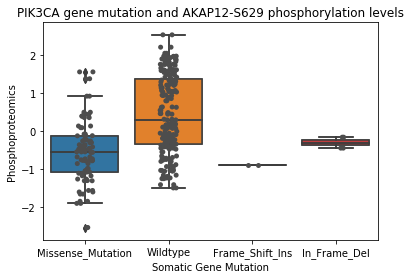

In [13]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

gene = 'PIK3CA'

site="AKAP12-S629"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)

#print(genedf)
#sites = phos.filter(regex=site)
#genedf = genedf.add(sites, fill_value=0)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

print("\n")

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")